In [1]:
import pandas as pd
from pathlib import Path
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
from PIL import Image
from PIL import ImageDraw
import json

In [2]:
data_path = Path("./data")

In [3]:
df_train = pd.read_csv(data_path / "train.csv")
display(df_train.head(10))
df_train.shape

id           organ data_source  img_height  img_width  pixel_size  \
0  10044        prostate         HPA        3000       3000         0.4   
1  10274        prostate         HPA        3000       3000         0.4   
2  10392          spleen         HPA        3000       3000         0.4   
3  10488            lung         HPA        3000       3000         0.4   
4  10610          spleen         HPA        3000       3000         0.4   
5  10611          kidney         HPA        3000       3000         0.4   
6  10651  largeintestine         HPA        3000       3000         0.4   
7  10666        prostate         HPA        3000       3000         0.4   
8  10703          spleen         HPA        3000       3000         0.4   
9  10892  largeintestine         HPA        3000       3000         0.4   

   tissue_thickness                                                rle   age  \
0                 4  1459676 77 1462675 82 1465674 87 1468673 92 14...  37.0   
1                 4  715707 2 718705 8 721703 11 724701 18 727692 3...  76.0   
2                 4  1228631 20 1231629 24 1234624 40 1237623 47 12...  82.0   
3                 4  3446519 15 3449517 17 3452514 20 3455510 24 34...  78.0   
4                 4  478925 68 481909 87 484893 105 487863 154 4908...  21.0   
5                 4  730193 18 733191 25 736191 25 739152 65 742149...  68.0   
6                 4  1240229 12 1243227 15 1246223 26 1249221 29 12...  83.0   
7                 4  2698231 7 2701231 7 2704226 16 2707221 25 2710...  57.0   
8                 4  811259 262 814258 264 817257 266 820256 267 82...  50.0   
9                 4  523786 3 526784 8 529782 8 532778 9 535642 25 ...  79.0   

      sex  
0    Male  
1    Male  
2    Male  
3    Male  
4  Female  
5  Female  
6    Male  
7    Male  
8  Female  
9  Female

(351, 10)

In [4]:
df_train.organ.unique(), df_train.data_source.unique()

(array(['prostate', 'spleen', 'lung', 'kidney', 'largeintestine'],
       dtype=object),
 array(['HPA'], dtype=object))

In [26]:
df_train.describe()

id   img_height    img_width    pixel_size  tissue_thickness  \
count    351.000000   351.000000   351.000000  3.510000e+02             351.0   
mean   16662.914530  2978.364672  2978.364672  4.000000e-01               4.0   
std     9863.945557    90.962085    90.962085  1.111808e-16               0.0   
min       62.000000  2308.000000  2308.000000  4.000000e-01               4.0   
25%     8229.000000  3000.000000  3000.000000  4.000000e-01               4.0   
50%    16609.000000  3000.000000  3000.000000  4.000000e-01               4.0   
75%    25630.500000  3000.000000  3000.000000  4.000000e-01               4.0   
max    32741.000000  3070.000000  3070.000000  4.000000e-01               4.0   

              age  
count  351.000000  
mean    60.364672  
std     16.013327  
min     21.000000  
25%     55.000000  
50%     60.000000  
75%     73.000000  
max     84.000000

In [27]:
len(df_train.iloc[0].rle)

53275

In [28]:
test_df = pd.read_csv(data_path / "test.csv")
display(test_df.head(10))
test_df.shape

id   organ data_source  img_height  img_width  pixel_size  \
0  10078  spleen      Hubmap        2023       2023      0.4945   

   tissue_thickness  
0                 4

(1, 7)

In [29]:
sample_df = pd.read_csv(data_path / "sample_submission.csv")
display(sample_df.head())
sample_df.shape

id    rle
0  10078  12 34

(1, 2)

In [30]:
with open("./data/train_annotations/62.json", "r") as f:
    data = json.load(f)

print(data[0][:10])

[[1539, 2010], [1538, 2011], [1531, 2011], [1530, 2012], [1526, 2012], [1525, 2013], [1516, 2013], [1515, 2014], [1507, 2014], [1506, 2015]]


In [31]:
df_train.loc[df_train.id == 62].rle.values[0][:100]

'4382055 23 4385050 34 4388048 44 4391045 57 4394043 67 4397042 73 4400040 78 4403039 81 4406038 85 4'

<AxesSubplot:>

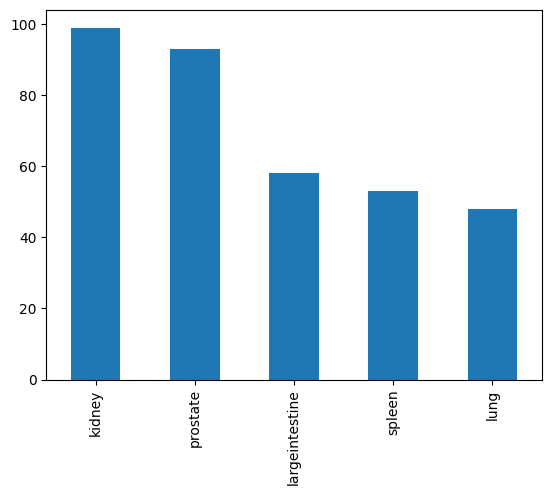

In [40]:
# Check organ kinds
df_train['organ'].value_counts().plot.bar()

In [37]:
# https://www.kaggle.com/code/utm529fg/eng-hubmap-hpa-visualize-all-train-data
# https://www.kaggle.com/code/pestipeti/decoding-rle-masks/notebook

def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def rle2mask(mask_rle, shape=(3000,3000)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

    
def show_image(idx,organ):
    fig, ax = plt.subplots(1, 3, figsize=(20, 40))
    df_organ = df_train[df_train['organ'] == organ].reset_index()
    image = plt.imread(f"./data/train_images/{df_organ.id[idx]}.tiff")
    mask = rle2mask(df_organ.rle[idx], shape=(df_organ.img_height[idx], df_organ.img_width[idx]))
    display(pd.DataFrame(df_organ.loc[idx, ['id', 'organ', 'age', 'sex']]).T)
    ax[0].imshow(image)
    ax[0].set_title("biopsy slide")
    ax[0].axis("off")
    ax[1].imshow(mask, alpha=0.3, cmap='gray')
    ax[1].set_title("mask")
    ax[1].axis("off")
    ax[2].imshow(image)
    ax[2].imshow(mask, alpha=0.3, cmap='gray')
    ax[2].axis("off")
    plt.show()
    print('-' * 50)

id     organ   age   sex
1  10274  prostate  76.0  Male

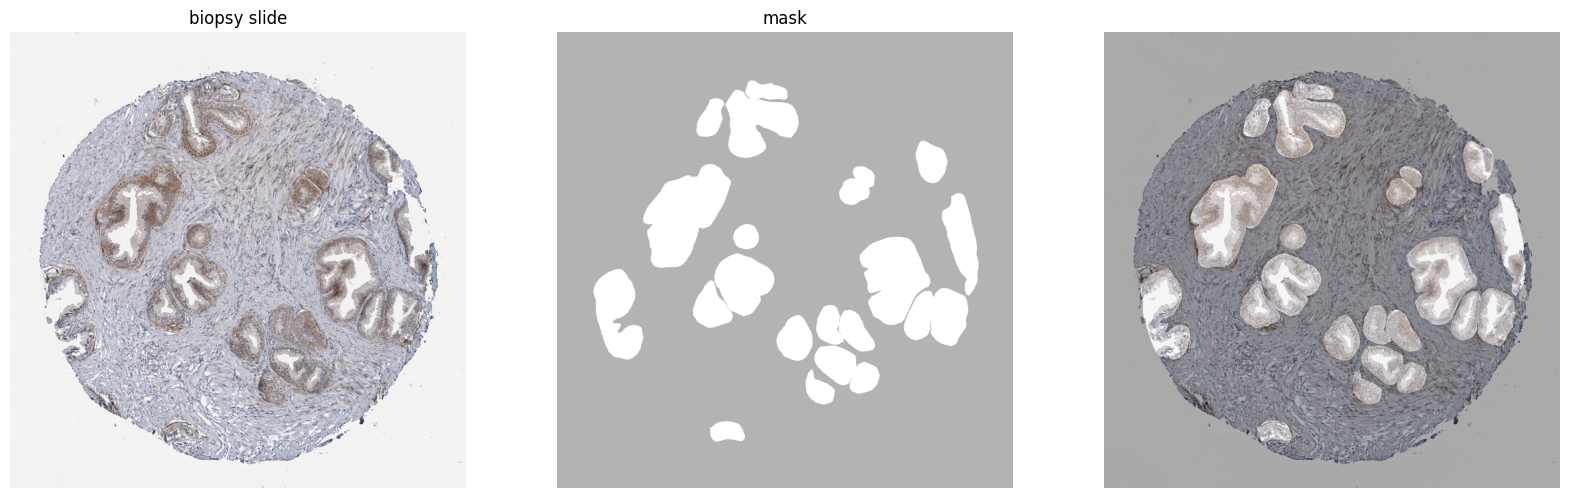

--------------------------------------------------


id   organ   age     sex
1  10610  spleen  21.0  Female

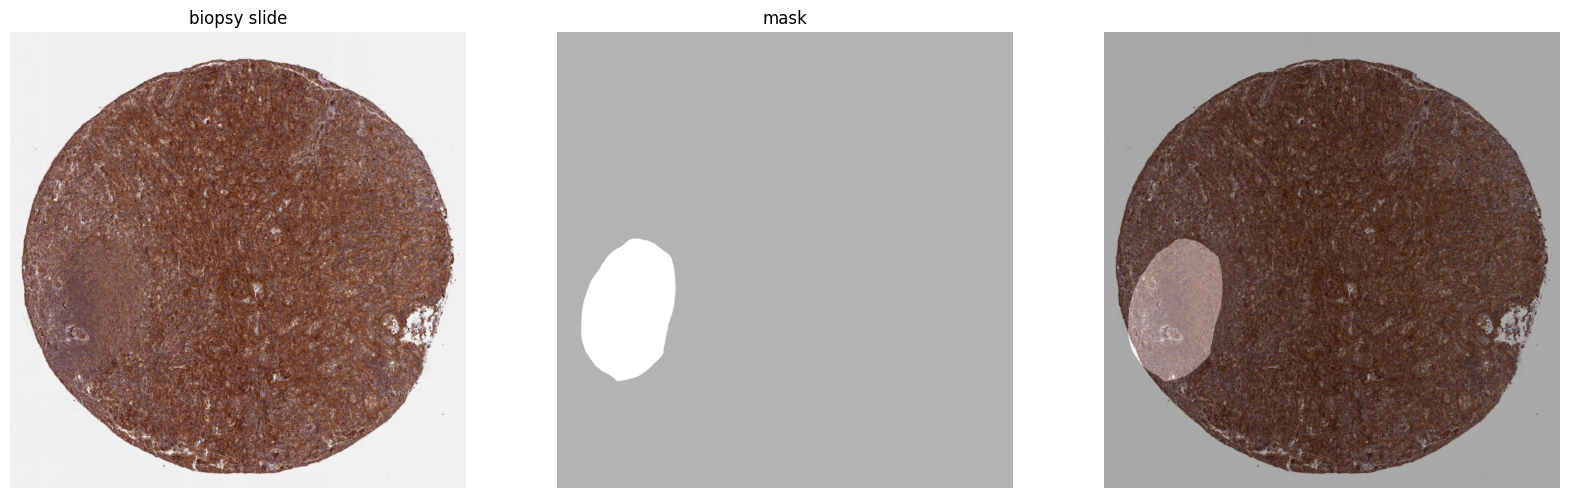

--------------------------------------------------


id organ   age   sex
1  11064  lung  65.0  Male

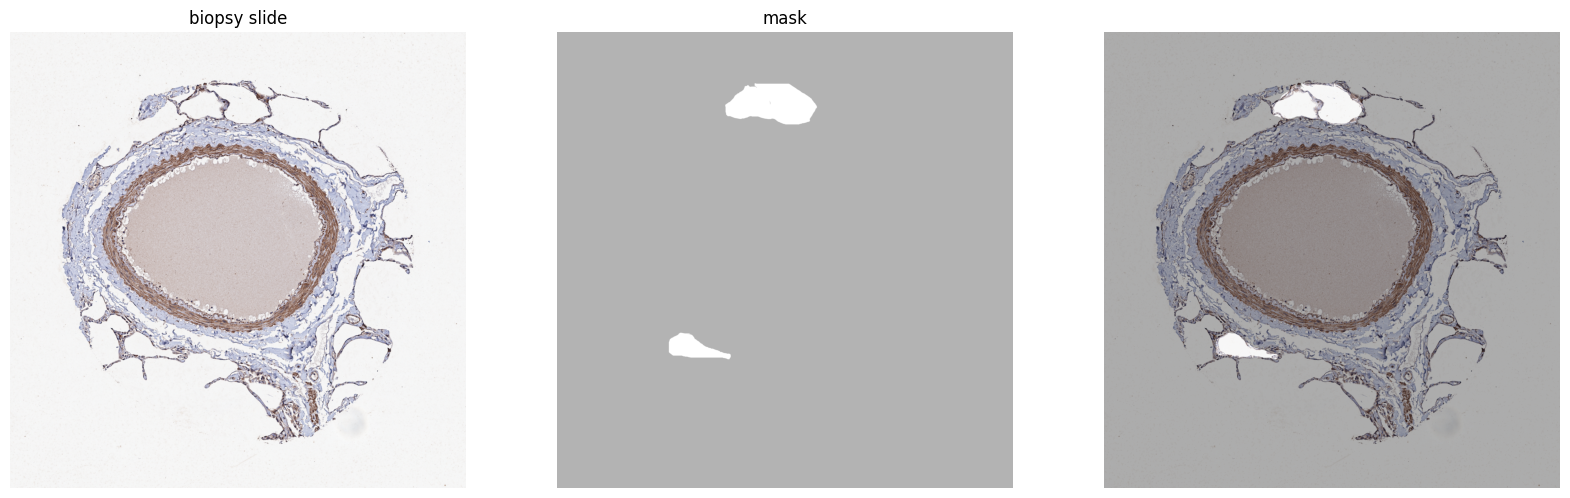

--------------------------------------------------


id   organ   age     sex
1  11497  kidney  41.0  Female

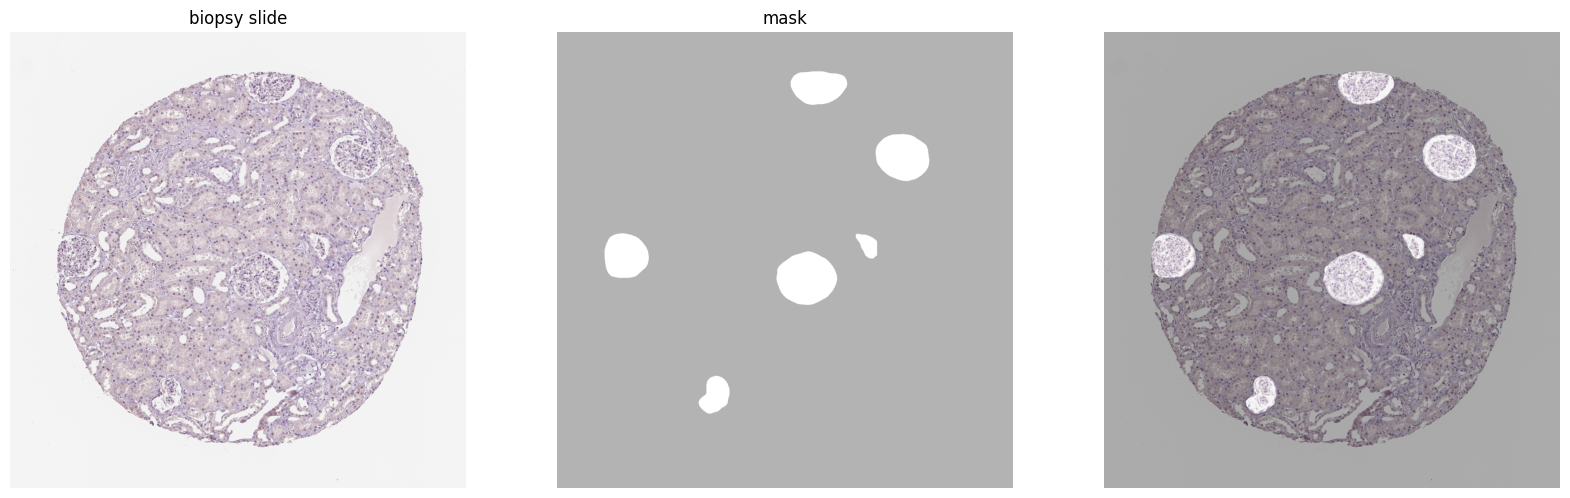

--------------------------------------------------


id           organ   age     sex
1  10892  largeintestine  79.0  Female

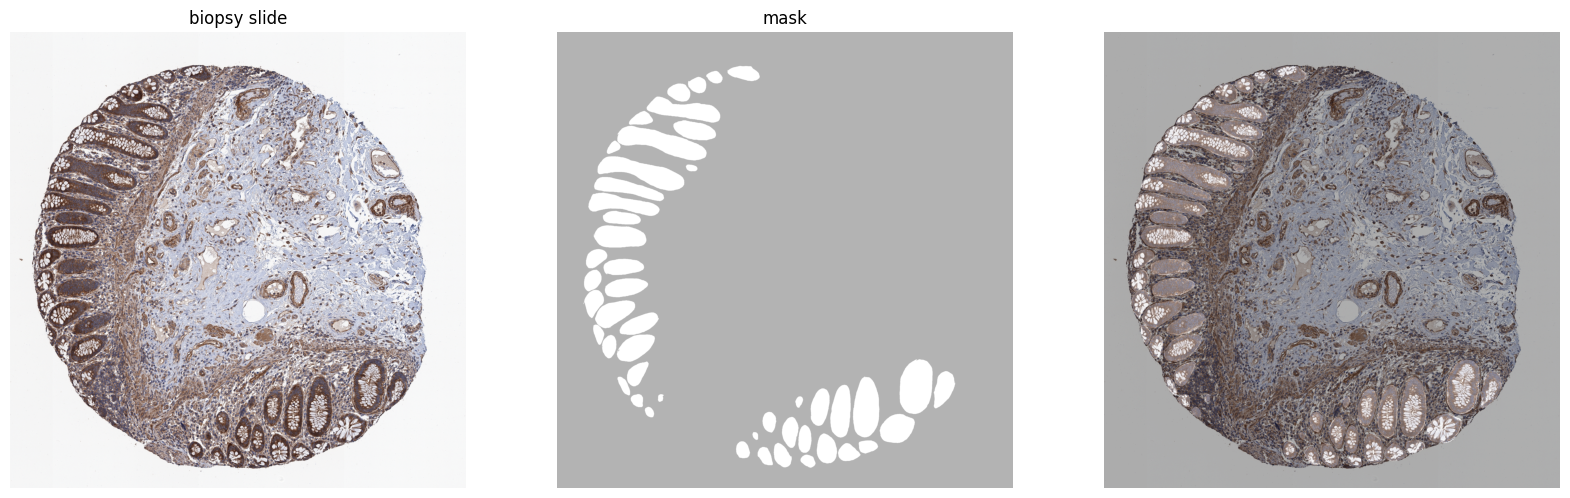

--------------------------------------------------


In [43]:
for organ in df_train.organ.unique():
    show_image(1, organ)

In [46]:
image = plt.imread(f"./data/train_images/{df_train.iloc[0].id}.tiff")
image.shape

(3000, 3000, 3)